In [1]:
from typing import NamedTuple, List, Tuple, Dict, Callable
from enum import Enum
from random import choice, uniform, choices
from copy import deepcopy
from heapq import heappush, heappop, _siftdown, _siftup
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
import pandas as pd
import numpy as np
import os
import math

### Clase ajutătoare

In [2]:
class Cell(Enum):
    FREE = 0
    OBSTACLE = 1
    CHEESE = 2

    FREE_STR = "🔹"
    OBSTACLE_STR = "🟪"
    CHEESE_STR = "🧀"
    MOUSE_STR = "🐭"
    CAT_STR = "🐱"
    DEATH_STR = "💀"

    def __str__(self):
        if self == self.FREE:
            return self.FREE_STR.value
        elif self == self.OBSTACLE:
            return self.OBSTACLE_STR.value
        elif self == self.CHEESE:
            return self.CHEESE_STR.value
        else:
            return "?"

class Grid(NamedTuple):
    height: int
    width: int
    cells: Tuple[Tuple[Cell]]


class Position(NamedTuple):
    row: int
    col: int


class Action(Enum):
    NORTH = (-1, 0)
    EAST = (0, 1)
    SOUTH = (1, 0)
    WEST = (0, -1)
    STAY = (0, 0)
    
    def __str__(self):
        if self == self.NORTH:
            return "moved NORTH"
        elif self == self.EAST:
            return "moved EAST"
        elif self == self.SOUTH:
            return "moved SOUTH"
        elif self == self.WEST:
            return "moved WEST"
        else:
            return "did not move"


class Status(Enum):
    PLAYING = 0
    WON = 1
    LOST = 2


ACTIONS = [_ for _ in Action if _ != Action.STAY]
MOVE_REWARD = -0.1
WIN_REWARD = 100.0
CHEESE_REWARD = 10.0
LOSE_REWARD = -100.0
LOST_SCORE_TH = -20.0

### Clasa principală

In [3]:
class State(NamedTuple):
    mouse: Position
    cat: Position
    grid: Grid

    cheese_left: int
    max_steps: int
    status: Status

    def __str__(self):
        cell_lines: List[List[str]] = []
        for cell_line in self.grid.cells:
            cell_lines.append([str(_) for _ in cell_line])
        if self.cat == self.mouse:
            cell_lines[self.cat.row][self.cat.col] = Cell.DEATH_STR.value
        else:
            cell_lines[self.cat.row][self.cat.col] = Cell.CAT_STR.value
            cell_lines[self.mouse.row][self.mouse.col] = Cell.MOUSE_STR.value

        return "\n".join(["".join(line) for line in cell_lines])


def read_state_from_file(file_path: str) -> State:
    if type(file_path) != str:
        raise TypeError(f"file_path is not a string (got type {type(file_path)})")

    if not os.path.isfile(file_path):
        raise ValueError(f"\"{file_path}\" is not a valid path to a file")

    with open(file_path, "rt") as f:
        lines = f.readlines()

    height, width = [int(_) for _ in lines[0].split(" ")]
    cells: List[Tuple[Cell]] = []
    cheese_left = 0
    for i in range(1, height + 1):
        cells_line = tuple([Cell(int(_)) for _ in lines[i].strip()])
        cells.append(cells_line)
        cheese_left += cells_line.count(Cell.CHEESE)
    grid = Grid(height, width, tuple(cells))

    max_steps = int(lines[height + 1])

    mouse_line = [int(_) for _ in lines[height + 2].split(" ")]
    mouse = Position(mouse_line[0], mouse_line[1])

    cat_line = [int(_) for _ in lines[height + 3].split(" ")]
    cat = Position(cat_line[0], cat_line[1])

    return State(mouse, cat, grid, cheese_left, max_steps, Status.PLAYING)


def is_valid_action(state: State, position: Position, action: Action) -> bool:
    if type(state) != State:
        raise TypeError(f"state is not a State object (got {type(state)})")
    if type(position) != Position:
        raise TypeError(f"position is not a Position object (got {type(position)})")
    if type(action) != Action:
        raise TypeError(f"action is not an Action object (got {type(action)})")

    row = position.row + action.value[0]
    col = position.col + action.value[1]
    next_pos = Position(row, col)
    if position == state.mouse and next_pos == state.cat:
        return False

    return 0 <= row < state.grid.height and \
           0 <= col < state.grid.width and \
           state.grid.cells[row][col] != Cell.OBSTACLE


def get_legal_actions(state: State, position: Position) -> List[Action]:
    if type(state) != State:
        raise TypeError(f"state is not a State object (got {type(state)})")
    if type(position) != Position:
        raise TypeError(f"position is not a Position object (got {type(position)})")

    legal_actions = [_ for _ in ACTIONS if is_valid_action(state, position, _)]
    if legal_actions == []:
        return [Action.STAY]
    return legal_actions


def __manhattan_distance(p1: Position, p2: Position) -> int:
    if type(p1) != Position:
        raise TypeError(f"p1 is not a Position object (got {type(p1)})")
    if type(p2) != Position:
        raise TypeError(f"p2 is not a Position object (got {type(p2)})")

    return abs(p1.row - p2.row) + abs(p1.col - p2.col)


def __h(state: State) -> float:
    return __manhattan_distance(state.mouse, state.cat)

def __g(state: State, parent: Dict[State, State]) -> int:
    cost = 0
    current = state
    while current is not None:
        cost += 1
        current = parent[current]
    return cost

def __goal(state: State) -> bool:
    return state.mouse == state.cat

def __succ(state: State) -> List[State]:
    next_states = []
    for action in get_legal_actions(state, state.cat):
        new_cat = Position(state.cat.row + action.value[0], state.cat.col + action.value[1])
        if state.mouse == new_cat:
            status = Status.LOST
        else:
            status = state.status
        
        next_states.append(State(state.mouse, new_cat, state.grid, state.cheese_left, 
                                 state.max_steps, status))
    return next_states
            

def __astar(s0):
    open_set = [(0, (0, s0))]
    count = 0
    parent = {s0: None}
    closed = []
    visited = set()
    while open_set:
        _, (_, current) = heappop(open_set)
        if __goal(current):
            #return current, parent
            prev = None
            curr = current
            while curr != s0:
                prev = curr
                curr = parent[curr]
            return prev.cat
        
        visited.add(current)
        closed.append(current)
        for next_state in __succ(current):
            if next_state in visited:
                continue
            
            parent[next_state] = current
            cost = __h(next_state) + __g(next_state, parent)
            
            # Iterate through closed and open sets separately
            for next_state_p in closed:
                if next_state == next_state_p:
                    if __g(next_state_p, parent) < __g(next_state, parent):
                        continue
                    else:
                        closed.remove(next_state_p)
            for i, (_, (_, next_state_p)) in enumerate(open_set):
                if next_state == next_state_p:
                    if __g(next_state_p, parent) < __g(next_state, parent):
                        continue
                    else:
                        open_set[i] = open_set[-1]
                        open_set.pop()
                        if i < len(open_set):
                            _siftup(open_set, i)
                            _siftdown(open_set, 0, i)
            parent[next_state] = current
            count += 1
            heappush(open_set, (cost, (count, next_state)))



def apply_action(state: State, action: Action) -> Tuple[State, float, str]:
    if type(state) != State:
        raise TypeError(f"state is not a State object (got {type(state)})")
    if type(action) != Action:
        raise TypeError(f"action is not an Action object (got {type(action)})")
    if not is_valid_action(state, state.mouse, action):
        accepted_actions = [_.name for _ in get_legal_actions(state, state.mouse)]
        raise ValueError(f"action is not valid (got {action.name}, accepted {accepted_actions})")

    grid_cells: List[List[Cell]] = [list(_) for _ in state.grid.cells]
    cheese_left: int = state.cheese_left
    status: Status = state.status

    # Move mouse
    mouse = Position(state.mouse.row + action.value[0], state.mouse.col + action.value[1])

    # Move cat
    steps_to_mouse = __manhattan_distance(state.cat, mouse)
    if steps_to_mouse > state.max_steps:
        if uniform(0, 1) <= 0.2:
            action_cat = Action.STAY
        else:
            action_cat = choice(get_legal_actions(state, state.cat))
        cat = Position(state.cat.row + action_cat.value[0], state.cat.col + action_cat.value[1])
        message_cat = f"Cat randomly {str(action_cat)}"
    else:
        cat = __astar(state)
        diff = (cat.row - state.cat.row, cat.col - state.cat.col)
        action_cat = None
        for action_ in Action:
            if action_.value == diff:
                action_cat = action_

        message_cat = f"Cat {str(action_cat)} to chase the mouse"
    
    # Parse state info
    if mouse == cat:
        status = Status.LOST
        reward = LOSE_REWARD
        message_mouse = f"Mouse {str(action)} and was chased by cat"
    elif cheese_left == 0:
        status = Status.WON
        reward = WIN_REWARD
        message_mouse = f"Mouse {str(action)} and ate the final piece of cheese"
    elif grid_cells[mouse.row][mouse.col] == Cell.CHEESE:
        cheese_left -= 1
        grid_cells[mouse.row][mouse.col] = Cell.FREE
        reward = CHEESE_REWARD
        message_mouse = f"Mouse {str(action)} and ate one piece of cheese"
    else:
        reward = MOVE_REWARD
        message_mouse = f"Mouse {str(action)}"
    
    grid = Grid(state.grid.height, state.grid.width, tuple([tuple(_) for _ in grid_cells]))
    message = message_mouse + ", " + message_cat
    return State(mouse, cat, grid, cheese_left, state.max_steps, status), reward, message


def is_final_state(state: State) -> bool:
    return state.status in [Status.WON, Status.LOST]


### Q-Learning

In [4]:
def max_reward_action(Q: Dict[Tuple[State, Action], float], state: State) -> Action:
    if type(Q) != dict:
        raise TypeError(f"Q is not a dictionary (got {type(Q)})")
    if type(state) != State:
        raise TypeError(f"state is not a State object (got {type(state)})")

    max_reward = -math.inf
    for (s, a), r in Q.items():
        if s == state and r > max_reward:
            max_reward = r

    best_actions = []
    for (s, a), r in Q.items():
        if s == state and r == max_reward:
            best_actions.append(a)

    if best_actions == []:
        return Action.STAY
    return choice(best_actions)


def max_first_strategy(Q: Dict[Tuple[State, Action], float], state: State, legal_actions: List[Action])\
        -> Action:
    if type(Q) != dict:
        raise TypeError(f"Q is not a dictionary (got {type(Q)})")
    if type(state) != State:
        raise TypeError(f"state is not a State object (got {type(state)})")
    if type(legal_actions) != list:
        raise TypeError(f"legal_actions is not a list (got {type(legal_actions)})")
    
    explored_actions =  [_ for _ in legal_actions if (state, _) in Q]
    if explored_actions == []:
        return choice(legal_actions)
    return max_reward_action(Q, state)


def random_strategy(Q: Dict[Tuple[State, Action], float], state: State, legal_actions: List[Action])\
        -> Action:
    if type(Q) != dict:
        raise TypeError(f"Q is not a dictionary (got {type(Q)})")
    if type(state) != State:
        raise TypeError(f"state is not a State object (got {type(state)})")
    if type(legal_actions) != list:
        raise TypeError(f"legal_actions is not a list (got {type(legal_actions)})")

    return choice(legal_actions)


def exploitation_strategy(Q: Dict[Tuple[State, Action], float], state: State, legal_actions: List[Action])\
        -> Action:
    if type(Q) != dict:
        raise TypeError(f"Q is not a dictionary (got {type(Q)})")
    if type(state) != State:
        raise TypeError(f"state is not a State object (got {type(state)})")
    if type(legal_actions) != list:
        raise TypeError(f"legal_actions is not a list (got {type(legal_actions)})")
    
    unexplored_actions =  [_ for _ in legal_actions if (state, _) not in Q]
    if unexplored_actions != []:
        return choice(unexplored_actions)
    return choice(legal_actions)


def weighted_exploitation_strategy(Q: Dict[Tuple[State, Action], float], state: State,
                                   legal_actions: List[Action]) -> Action:
    if type(Q) != dict:
        raise TypeError(f"Q is not a dictionary (got {type(Q)})")
    if type(state) != State:
        raise TypeError(f"state is not a State object (got {type(state)})")
    if type(legal_actions) != list:
        raise TypeError(f"legal_actions is not a list (got {type(legal_actions)})")
    
    weights = {}
    for action in legal_actions:
        weights[action] = 0.0
    
    for (s, a), r in Q.items():
        if s == state:
            weights[a] += r
    
    # Translate data so that the minimum value is 0
    weights_min = min(weights.values())
    for k in weights.keys():
        weights[k] -= weights_min
    
    weights_sum = sum(weights.values())

    if weights_sum == 0:
        return choice(legal_actions)
    
    # Normalize data
    for a, w in weights.items():
        weights[a] /= weights_sum
    
    return choices(weights.keys(), weights.values())

In [5]:
class Strategy(Enum):
    MAX_FIRST = "Max First"
    RANDOM = "Random"
    EXPLOITATION = "Exploitation"
    WEIGHTED_EXPLOITATION = "Weighted Exploitation"
    
    def __str__(self):
        return self.value


def q_learning_train(init_state: State, learning_rate: float, discount_factor: float,
                     train_episodes: int, strategy: Strategy, should_print: bool = False)\
        -> Tuple[Dict[Tuple[State, Action], float], List[float]]:

    if type(init_state) != State:
        raise TypeError(f"init_state is not a State object (got {type(init_state)})")
    if type(learning_rate) != float:
        raise TypeError(f"learning_rate is not a floating point number (got {type(learning_rate)})")
    if type(discount_factor) != float:
        raise TypeError(f"learning_rate is not a floating point number (got {type(discount_factor)})")
    if type(train_episodes) != int:
        raise TypeError(f"train_episodes is not an integer number (got {type(train_episodes)})")
    if type(strategy) != Strategy:
        raise TypeError(f"strategy is not a Strategy object (got {type(strategy)})")

    if not 0.0 < learning_rate <= 1.0:
        raise ValueError("learning_rate must be between 0.0 and 1.0")
    if not 0.0 <= discount_factor <= 1.0:
        raise ValueError("discount_factor must be between 0.0 and 1.0")
    if not 0 < train_episodes:
        raise ValueError("train_episodes is not a positive integer")
      
    if strategy == Strategy.MAX_FIRST:
        strat_func = max_first_strategy
    elif strategy == Strategy.RANDOM:
        strat_func = random_strategy
    elif strategy == Strategy.EXPLOITATION:
        strat_func = exploitation_strategy
    elif strategy == Strategy.WEIGHTED_EXPLOITATION:
        strat_func = exploitation_strategy
    
    Q: Dict[Tuple[State, Action], float] = {}
    train_scores: List[float] = []
    for train_episode in range(1, train_episodes + 1):
        state = deepcopy(init_state)
        score = 0
        reward = 0

        while not is_final_state(state) and score > LOST_SCORE_TH:
            legal_actions = get_legal_actions(state, state.mouse)
            action = strat_func(Q, state, legal_actions)

            state_p, reward, _ = apply_action(state, action)
            score += reward

            q_s_a = Q.get((state, action), 0.0)
            max_q_sp_ap = Q.get((state, max_reward_action(Q, state_p)), 0.0)
            Q[(state, action)] = \
                q_s_a + learning_rate * (reward + discount_factor * max_q_sp_ap - q_s_a)
            state = state_p

        if should_print:
            clear_output(wait=True)
            print(f"Episode {train_episode} / {train_episodes}")
        train_scores.append(score)

    return Q, train_scores


def q_learning_test(Q: Dict[Tuple[State, Action], float], init_state: State, max_iter: int,
                    should_print: bool = False) -> Status:
    state = deepcopy(init_state)
    iter = 0

    while not is_final_state(state) and iter < max_iter:
        action = max_reward_action(Q, state)
        state, _, msg = apply_action(state, action)
        if should_print:
            clear_output(wait=True)
            print(msg)
            print(state)
            sleep(1)
    
        iter += 1

    if iter >= max_iter:
        if should_print:
            clear_output(wait=True)
            print("Exceeded maximum number of iterations")
        return Status.LOST
    return state.status


def q_learning_plot(train_sccores: List[float], eval_interval: int):
    train_episodes = len(train_sccores)
    eval_scores = []
    for i in range(0, train_episodes, eval_interval):
        eval_scores.append(train_sccores[i] / train_episodes)
    
    plt.xlabel("Episode")
    plt.ylabel("Average score")
    plt.plot(
        np.linspace(1, train_episodes, train_episodes),
        np.convolve(train_scores, [0.2, 0.2, 0.2, 0.2, 0.2], "same"),
        linewidth=1.0, color="blue"
    )
    plt.plot(
        np.linspace(eval_interval, train_episodes, len(eval_scores)),
        eval_scores, linewidth=2.0, color="red"
    )
    plt.show()

In [6]:
EPISODES = [500, 1000, 1500]
LEARNING_RATES = [0.1, 0.3, 0.5]
DISCOUNT_FACTORS = [0.66, 0.88, 0.99]
STRATEGIES = [Strategy.MAX_FIRST, Strategy.RANDOM, Strategy.EXPLOITATION, Strategy.WEIGHTED_EXPLOITATION]
BATCH_SIZE = 100

index = pd.MultiIndex.from_product(
    [EPISODES, LEARNING_RATES, DISCOUNT_FACTORS, STRATEGIES],
    names = ["Training Episodes", "Learning Rate", "Discount Factor", "Strategy"]
)
data = {
    "Win Rate": [0.0] * (len(EPISODES) * len(LEARNING_RATES) * len(DISCOUNT_FACTORS) * len(STRATEGIES)),
    "Train Scores": [[0]] * (len(EPISODES) * len(LEARNING_RATES) * len(DISCOUNT_FACTORS) * len(STRATEGIES)),
    "Q": [{}] * (len(EPISODES) * len(LEARNING_RATES) * len(DISCOUNT_FACTORS) * len(STRATEGIES))
}
scores = pd.DataFrame(data, index=index)

In [7]:
MAP = "small_map"
MAX_TEST_ITER = 100
load_from_file = True

if load_from_file:
    scores = pd.read_pickle(f"results_{MAP}.pkl", compression="xz")
else:
    for episodes in EPISODES:
        for learning_rate in LEARNING_RATES:
            for discount_factor in DISCOUNT_FACTORS:
                for strategy in STRATEGIES:
                    print(f"Testing {episodes} {learning_rate} {discount_factor} {str(strategy)}")
                    init_state = read_state_from_file(MAP)
                    Q, train_scores = q_learning_train(init_state, learning_rate, discount_factor,
                                                       episodes, strategy)
                    # Batch Test
                    times_won = 0
                    for i in range(BATCH_SIZE):
                        if q_learning_test(Q, init_state, MAX_TEST_ITER) == Status.WON:
                            times_won += 1
                    scores.loc[episodes, learning_rate, discount_factor, strategy] = (
                        times_won / BATCH_SIZE, train_scores, Q
                    )
    scores.to_pickle(f"results_{MAP}.pkl", compression="xz")

In [8]:
print(read_state_from_file(MAP))

🟪🟪🟪🟪🟪🟪🟪🟪
🟪🔹🔹🔹🔹🔹🔹🟪
🟪🐭🟪🔹🟪🔹🟪🟪
🟪🔹🔹🔹🔹🔹🔹🟪
🟪🧀🧀🔹🔹🔹🔹🟪
🟪🔹🔹🟪🔹🔹🐱🟪
🟪🟪🟪🟪🟪🟪🟪🟪


In [9]:
def plot_graphs_score_evolution(strategy: Strategy):
    plt.rcdefaults()
    plt.rc('font', size=20)
    cmap = plt.cm.get_cmap('Purples')
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))
    
    fig.suptitle("Evolutia scorului în funcție de numărul episodului de antrenament"
                 f"\n pentru strategia {str(strategy)}", fontsize=24)
    
    plt.figtext(0.5, 0.01, "Episod", horizontalalignment='center', size="x-large") 
    plt.figtext(0.01, 0.5, "Scor", verticalalignment='center', size="x-large", rotation="vertical")
    
    eval_interval = 10

    for i in range(3):
        for j in range(3):
            train_scores = scores.loc[1000, LEARNING_RATES[i], DISCOUNT_FACTORS[j], strategy]["Train Scores"]

            train_episodes = len(train_scores)
            eval_scores = []
            for idx in range(0, train_episodes, eval_interval):
                eval_scores.append(train_scores[idx] / train_episodes)

            axs[i, j].set(xlabel=f"gamma {DISCOUNT_FACTORS[j]}", ylabel=f"alpha {LEARNING_RATES[i]}")
            axs[i, j].plot(
                np.linspace(1, train_episodes, train_episodes),
                np.convolve(train_scores, [0.2, 0.2, 0.2, 0.2, 0.2], "same"),
                linewidth=1.0, color=cmap(0.3 + (i + j) / 9)
            )
            axs[i, j].plot(
                np.linspace(eval_interval, train_episodes, len(eval_scores)),
                eval_scores, linewidth=2.0, color="red"
            )

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

        
def autolabel(rects):
    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        ha = 'left'

        # If value of bar is negative: Place label left of bar
        if x_value < 0:
            # Invert space to place label to the left
            space *= -1
            # Horizontally align label at right
            ha = 'right'

        # Use X value as label and format number with one decimal place
        label = "{:.3f}".format(x_value)

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space, 0),          # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            va='center',                # Vertically center label
            ha=ha)                      # Horizontally align label differently for
                                        # positive and negative values.
        

def plot_graph_win_rate(strategy: Strategy):
    plt.rcdefaults()
    plt.rc('font', size=10)
    
    labels = [0.1, 0.3, 0.5]
    values1 = [scores.loc[1000, _, 0.66, strategy]["Win Rate"] for _ in labels]
    values2 = [scores.loc[1000, _, 0.88, strategy]["Win Rate"] for _ in labels]
    values3 = [scores.loc[1000, _, 0.99, strategy]["Win Rate"] for _ in labels]
    
    x = np.arange(len(labels))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(6,6))
    rects1 = ax.barh(x + width, values1, width, label="gamma 0.66")
    rects2 = ax.barh(x,         values2, width, label="gamma 0.88")
    rects3 = ax.barh(x - width, values3, width, label="gamma 0.99")
    
    ax.set_title("Procentul de jocuri câștigate în funcție de valorile factorilor de învățare"
                 f"\n și discount pentru strategia {str(strategy)}", y=1.1)
    ax.set_xlabel("Procent")
    ax.set_xlim(xmin=0.0, xmax=1.0)
    ax.set_yticks(x)
    ax.set_yticklabels(["alpha 0.1", "alpha 0.3", "alpha 0.5"])
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3, fancybox=True, shadow=True)
    
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    
    plt.show()


def plot_graph_q_max_first():
    plt.rcdefaults()
    plt.rc('font', size=20)
    cmap = plt.cm.get_cmap('Purples')
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))
    
    fig.suptitle("Cum afectează numărul de episoade de antrenament media valorile din tabela de utilități"
                 " în cazul strategiei Max First", fontsize=24)
    plt.figtext(0.5, 0.01, "Număr episoade", horizontalalignment='center', size="x-large") 
    plt.figtext(0.01, 0.5, "Media valorilor din Q", verticalalignment='center', size="x-large",
                rotation="vertical")

    for i in range(3):
        for j in range(3):
            averages = []
            for ep in EPISODES:
                Q = scores.loc[ep, LEARNING_RATES[i], DISCOUNT_FACTORS[j], Strategy.MAX_FIRST]["Q"]
                averages.append(sum(Q.values()) / len(Q.values()))
            
            if j == 0 and i == 2:
                axs[i, j].set(xlabel=f"gamma {DISCOUNT_FACTORS[j]}", ylabel=f"alpha {LEARNING_RATES[i]}")
            elif j == 0:
                axs[i, j].set(ylabel=f"alpha {LEARNING_RATES[i]}")
            elif i == 2:
                axs[i, j].set(xlabel=f"gamma {DISCOUNT_FACTORS[j]}")
            axs[i, j].plot(EPISODES, averages, "-o", color="purple")

            
def plot_graph_q_max_first_random():
    plt.rcdefaults()
    plt.rc('font', size=20)
    cmap = plt.cm.get_cmap('Purples')
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))
    
    fig.suptitle("Cum afectează numărul de episoade de antrenament media valorile din tabela de utilități"
                 "\n în cazul strategiilor Max First și Random", fontsize=24)
    plt.figtext(0.5, 0.01, "Număr episoade", horizontalalignment='center', size="x-large") 
    plt.figtext(0.01, 0.5, "Media valorilor din Q", verticalalignment='center', size="x-large",
                rotation="vertical")
    l1 = l2 = None

    for i in range(3):
        for j in range(3):
            averages_max_first = []
            averages_random = []
            for ep in EPISODES:
                Q = scores.loc[ep, LEARNING_RATES[i], DISCOUNT_FACTORS[j], Strategy.MAX_FIRST]["Q"]
                averages_max_first.append(sum(Q.values()) / len(Q.values()))
                Q = scores.loc[ep, LEARNING_RATES[i], DISCOUNT_FACTORS[j], Strategy.RANDOM]["Q"]
                averages_random.append(sum(Q.values()) / len(Q.values()))
            
            if j == 0 and i == 2:
                axs[i, j].set(xlabel=f"gamma {DISCOUNT_FACTORS[j]}", ylabel=f"alpha {LEARNING_RATES[i]}")
            elif j == 0:
                axs[i, j].set(ylabel=f"alpha {LEARNING_RATES[i]}")
            elif i == 2:
                axs[i, j].set(xlabel=f"gamma {DISCOUNT_FACTORS[j]}")
            l1 = axs[i, j].plot(EPISODES, averages_max_first, "-o", color="purple")
            l2 = axs[i, j].plot(EPISODES, averages_random, "-o", color="turquoise")

    fig.legend((l1, l2), labels=["Max First", "Random"], loc="upper center", bbox_to_anchor=(0.5, 0.94), 
               ncol=3, fancybox=True, shadow=True)

            
def plot_graph_q_max_first_random_neg():
    plt.rcdefaults()
    plt.rc('font', size=20)
    cmap = plt.cm.get_cmap('Purples')
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))
    
    fig.suptitle("Numărul de valori negative din tabela de utilități în cazul strategiilor"
                 "\n Max First și Random", fontsize=24)
    plt.figtext(0.5, 0.01, "Număr episoade", horizontalalignment='center', size="x-large") 
    plt.figtext(0.01, 0.5, "Numărul valorilor negative din Q", verticalalignment='center', size="x-large",
                rotation="vertical")
    l1 = l2 = None

    for i in range(3):
        for j in range(3):
            negatives_max_first = []
            negatives_random = []
            for ep in EPISODES:
                Q = scores.loc[ep, LEARNING_RATES[i], DISCOUNT_FACTORS[j], Strategy.MAX_FIRST]["Q"]
                negatives_max_first.append(len([_ for _ in Q.values() if _ < 0]))
                Q = scores.loc[ep, LEARNING_RATES[i], DISCOUNT_FACTORS[j], Strategy.RANDOM]["Q"]
                negatives_random.append(len([_ for _ in Q.values() if _ < 0]))
            
            if j == 0 and i == 2:
                axs[i, j].set(xlabel=f"gamma {DISCOUNT_FACTORS[j]}", ylabel=f"alpha {LEARNING_RATES[i]}")
            elif j == 0:
                axs[i, j].set(ylabel=f"alpha {LEARNING_RATES[i]}")
            elif i == 2:
                axs[i, j].set(xlabel=f"gamma {DISCOUNT_FACTORS[j]}")
            l1 = axs[i, j].plot(EPISODES, negatives_max_first, "-o", color="purple")
            l2 = axs[i, j].plot(EPISODES, negatives_random, "-o", color="turquoise")

    fig.legend((l1, l2), labels=["Max First", "Random"], loc="upper center", bbox_to_anchor=(0.5, 0.94), 
               ncol=3, fancybox=True, shadow=True)

# Grafice comparative

## Max First

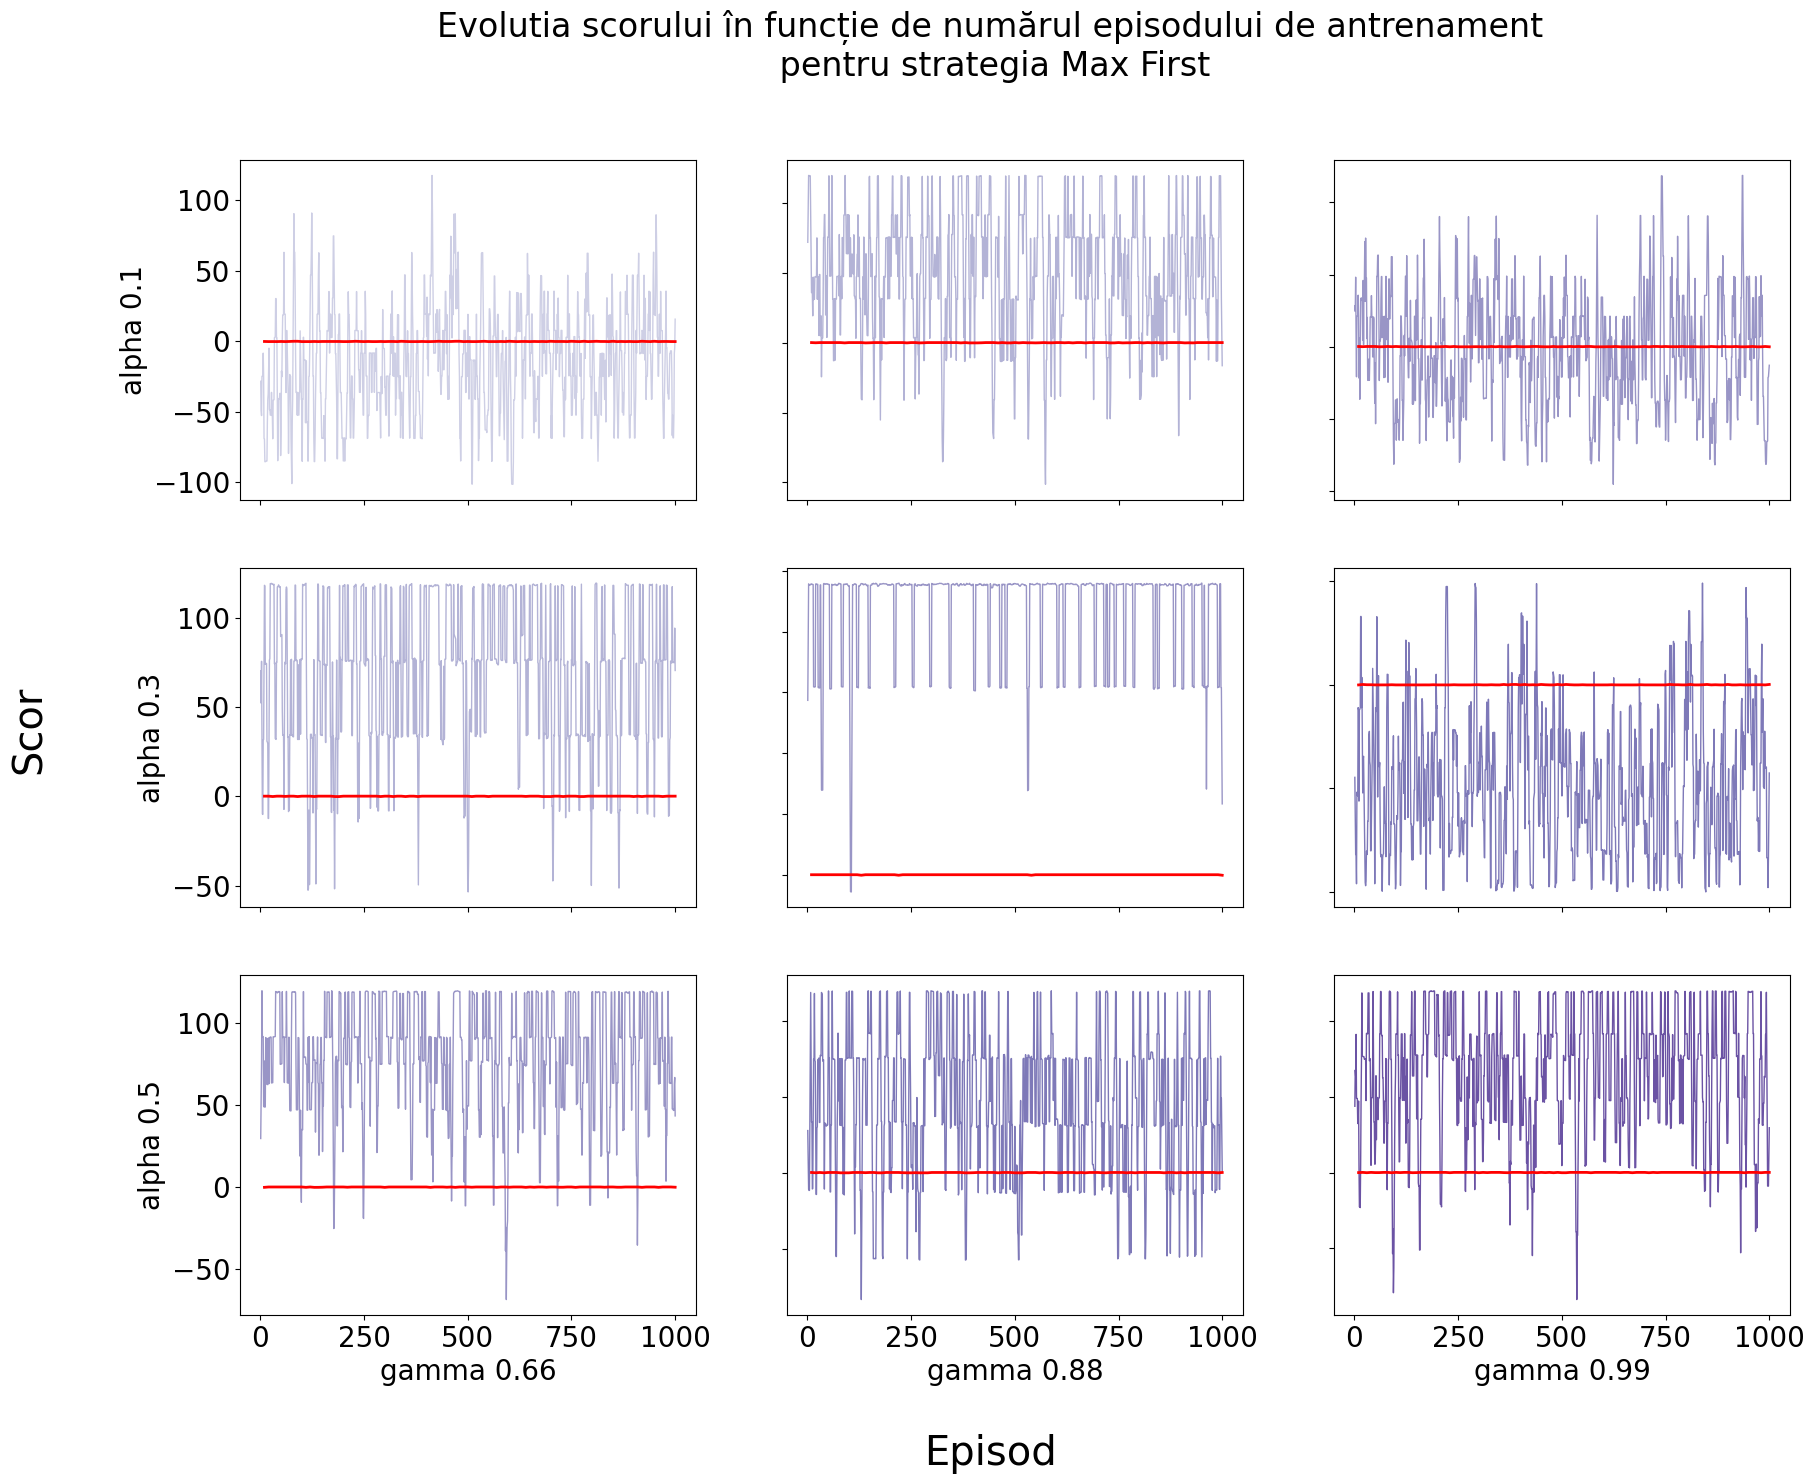

In [10]:
plot_graphs_score_evolution(Strategy.MAX_FIRST)

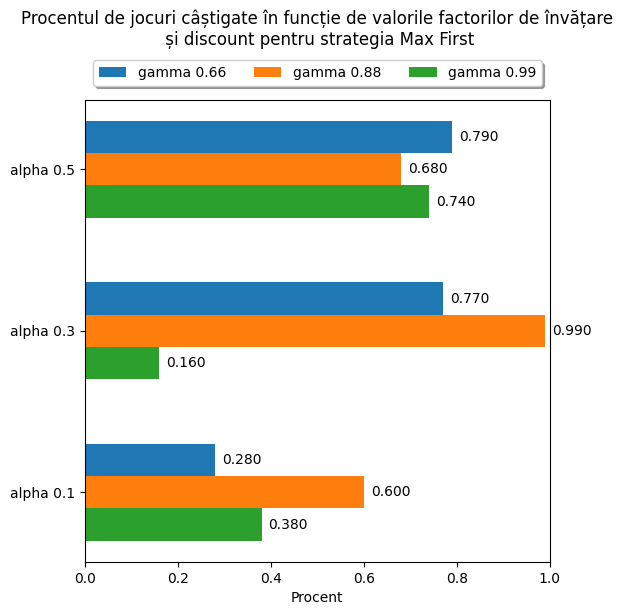

In [11]:
plot_graph_win_rate(Strategy.MAX_FIRST)

## Random

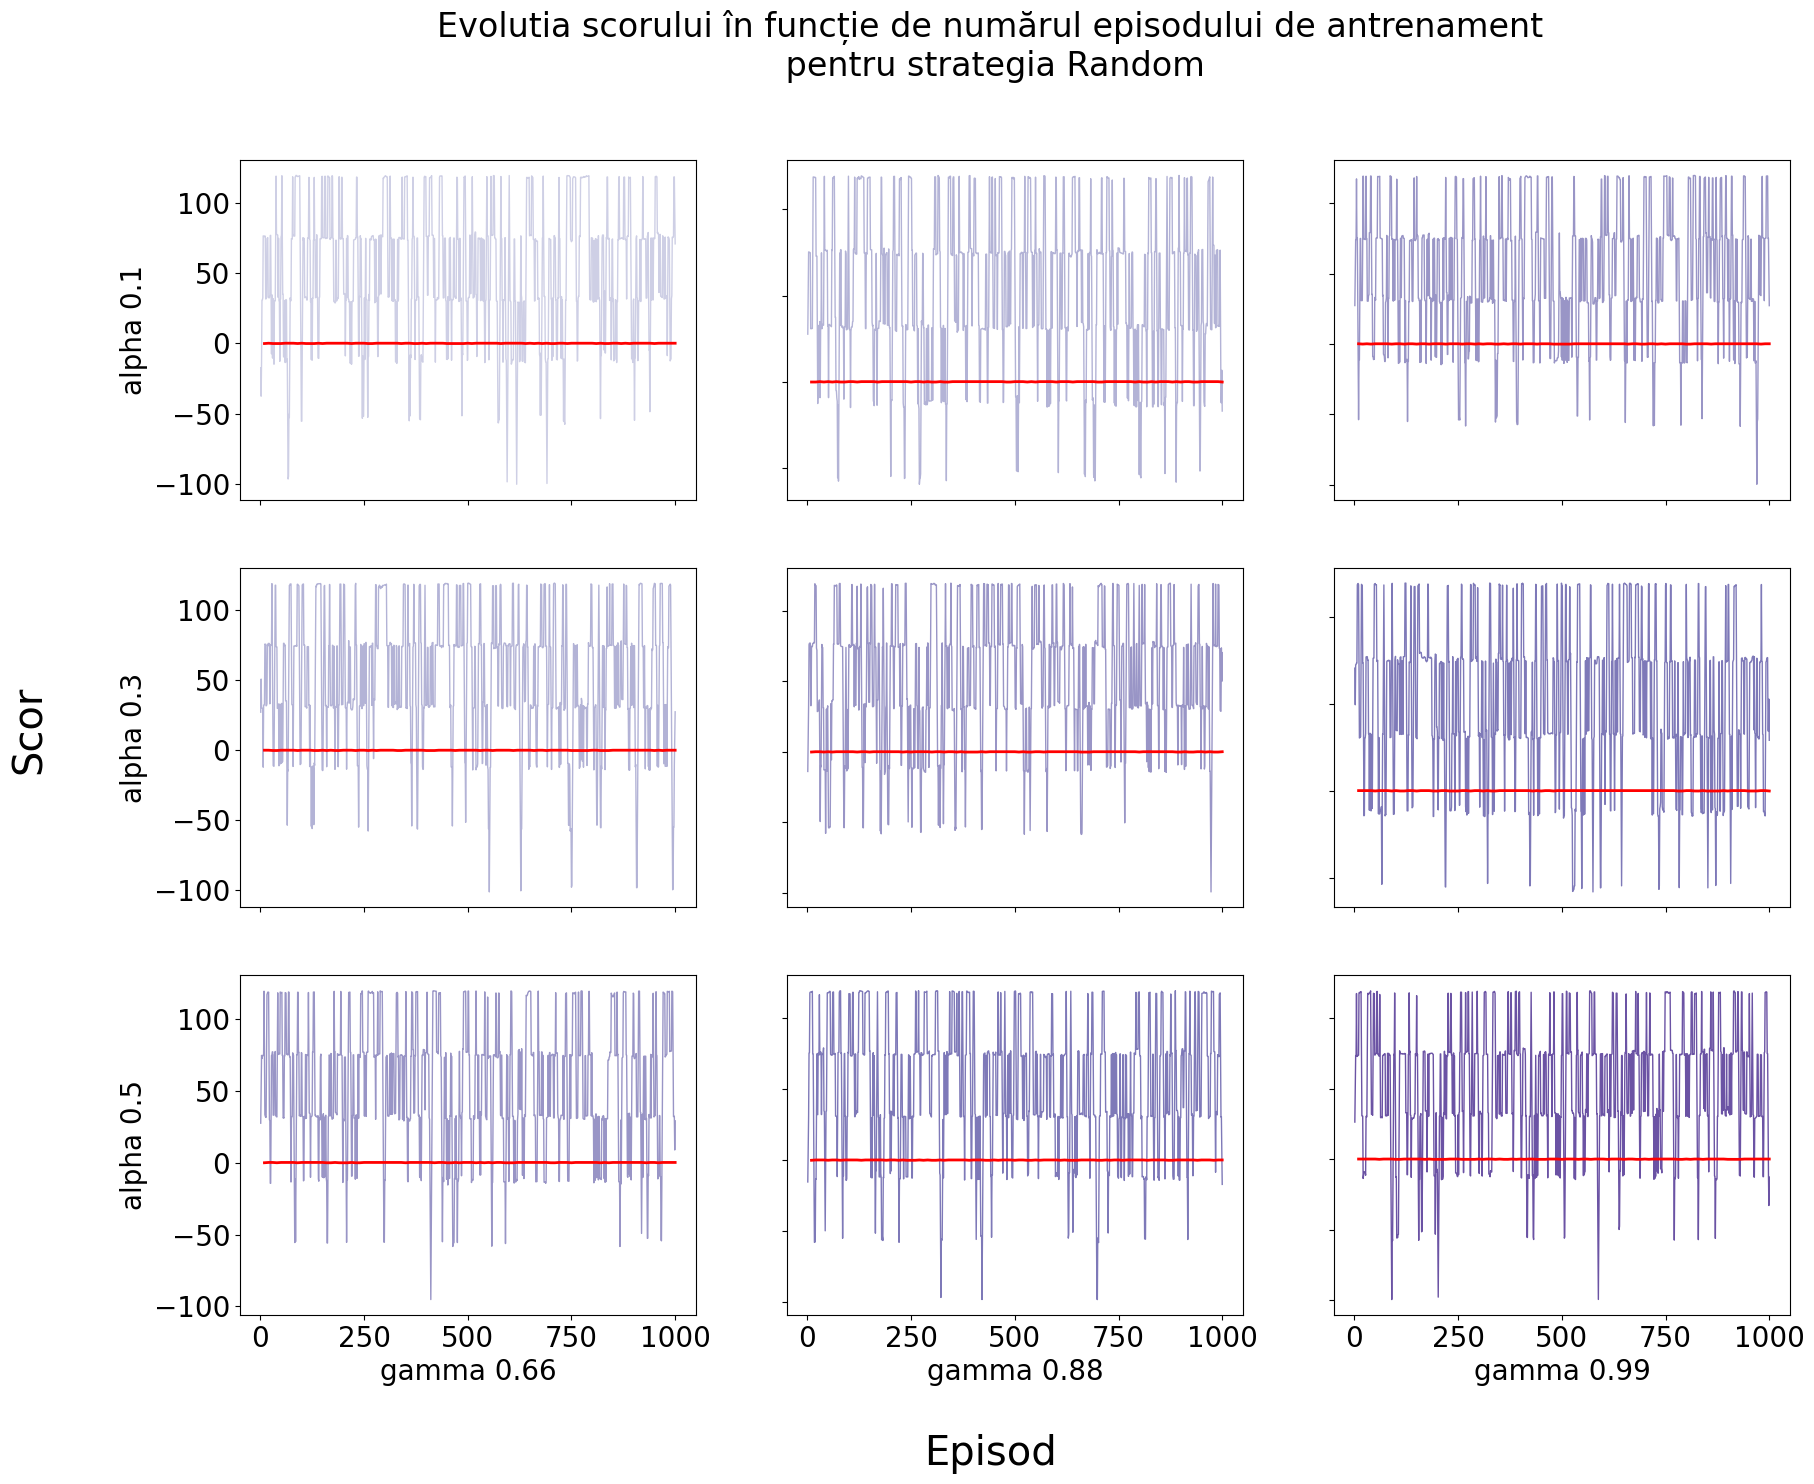

In [12]:
plot_graphs_score_evolution(Strategy.RANDOM)

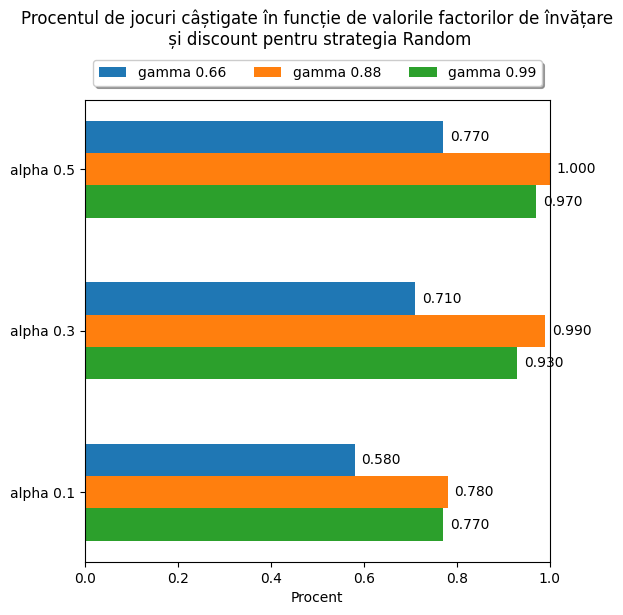

In [13]:
plot_graph_win_rate(Strategy.RANDOM)

## Exploatare

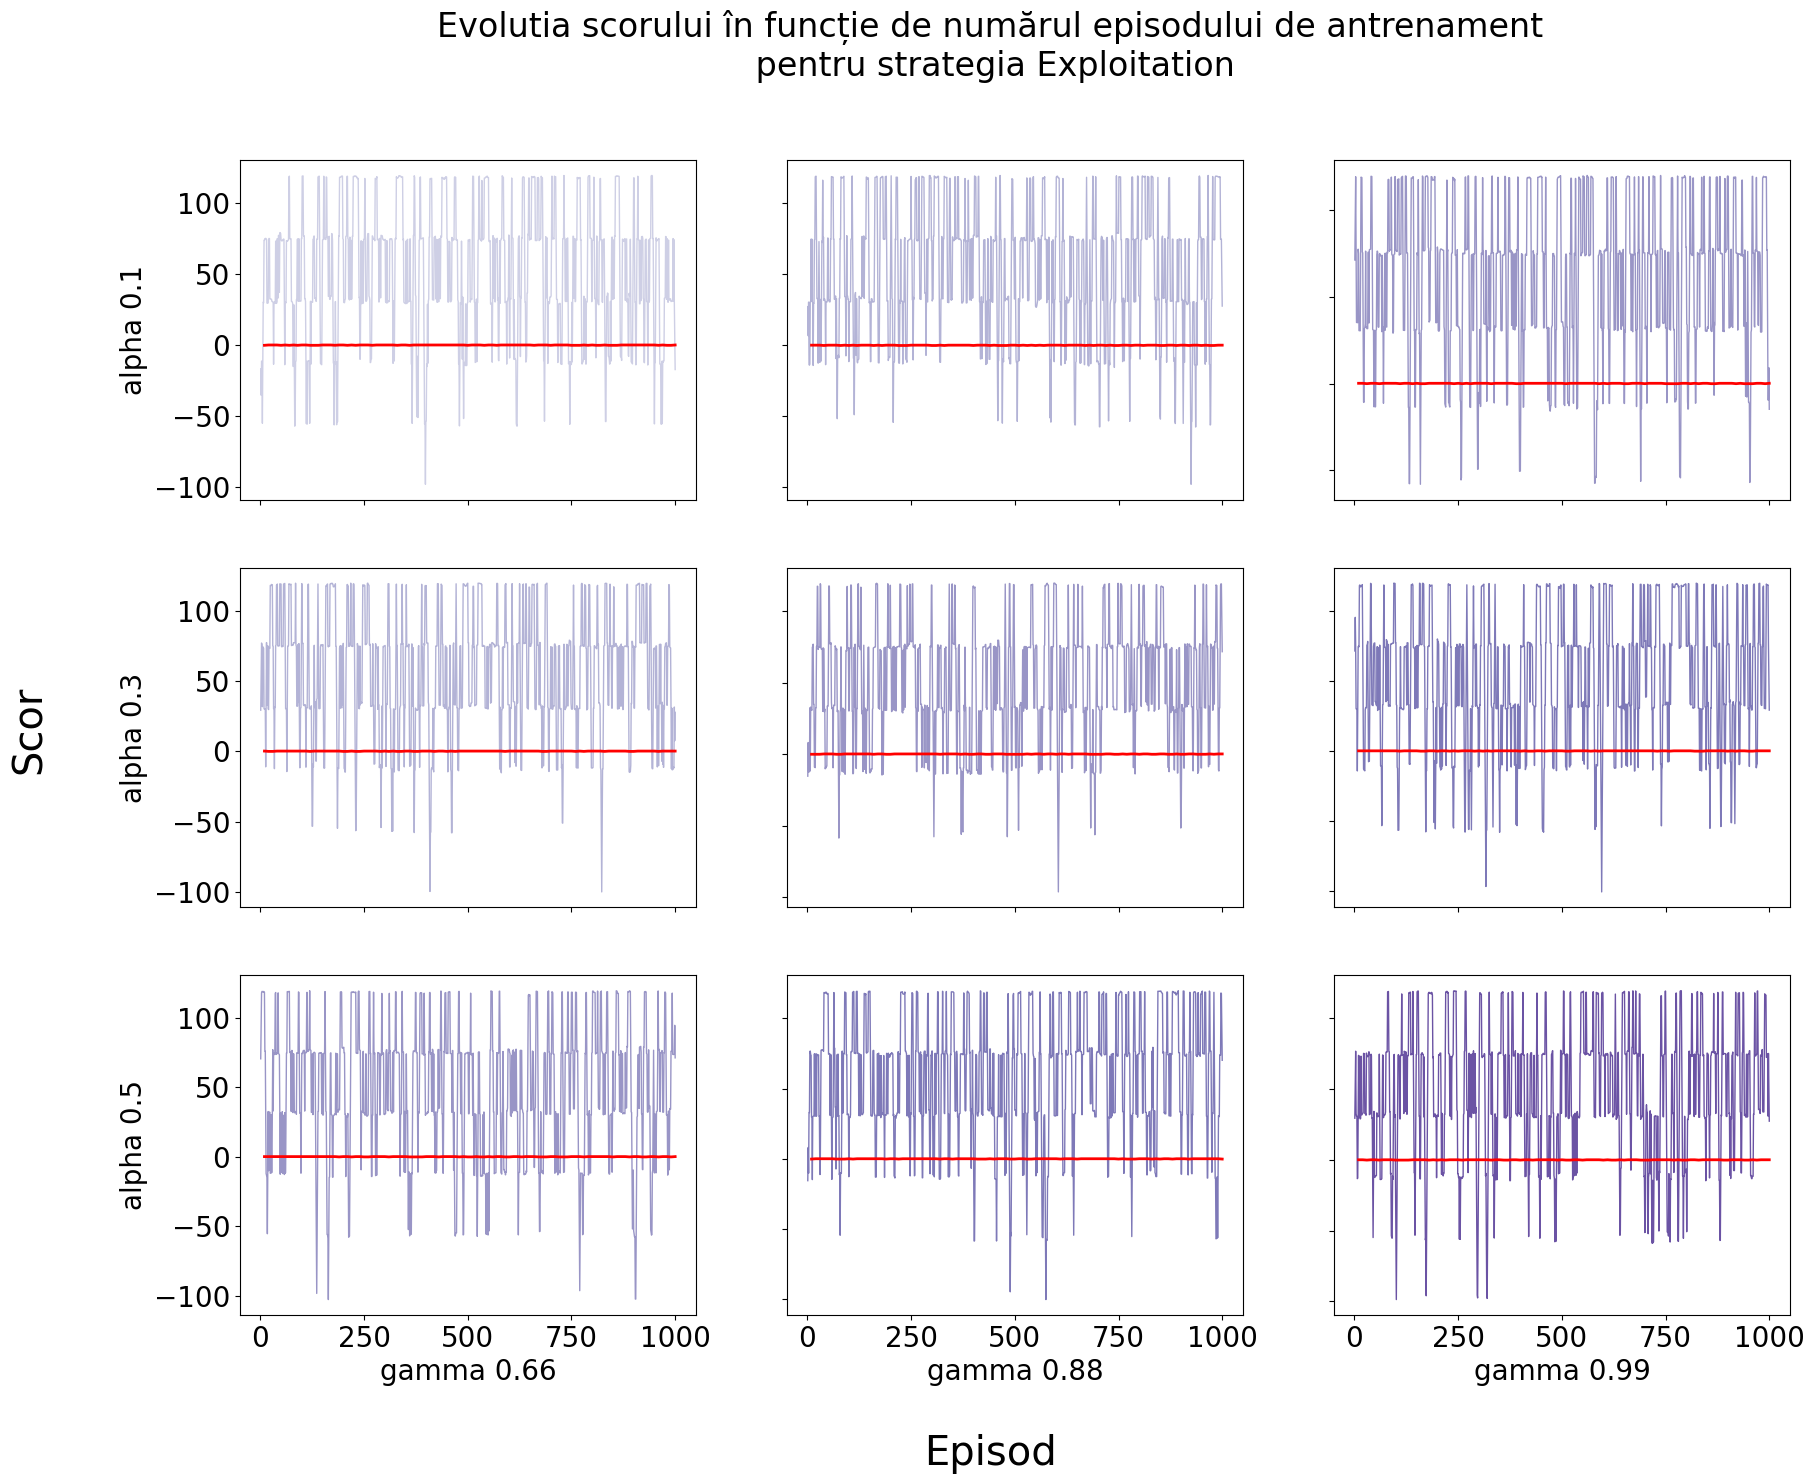

In [14]:
plot_graphs_score_evolution(Strategy.EXPLOITATION)

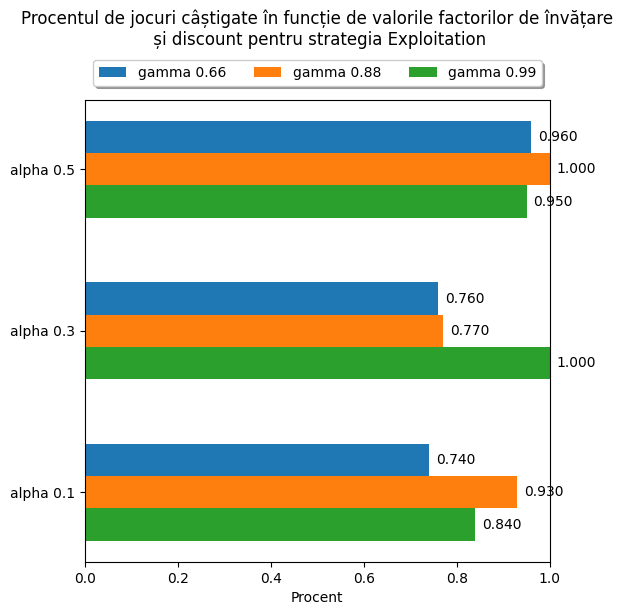

In [15]:
plot_graph_win_rate(Strategy.EXPLOITATION)

## Exploatare Ponderată

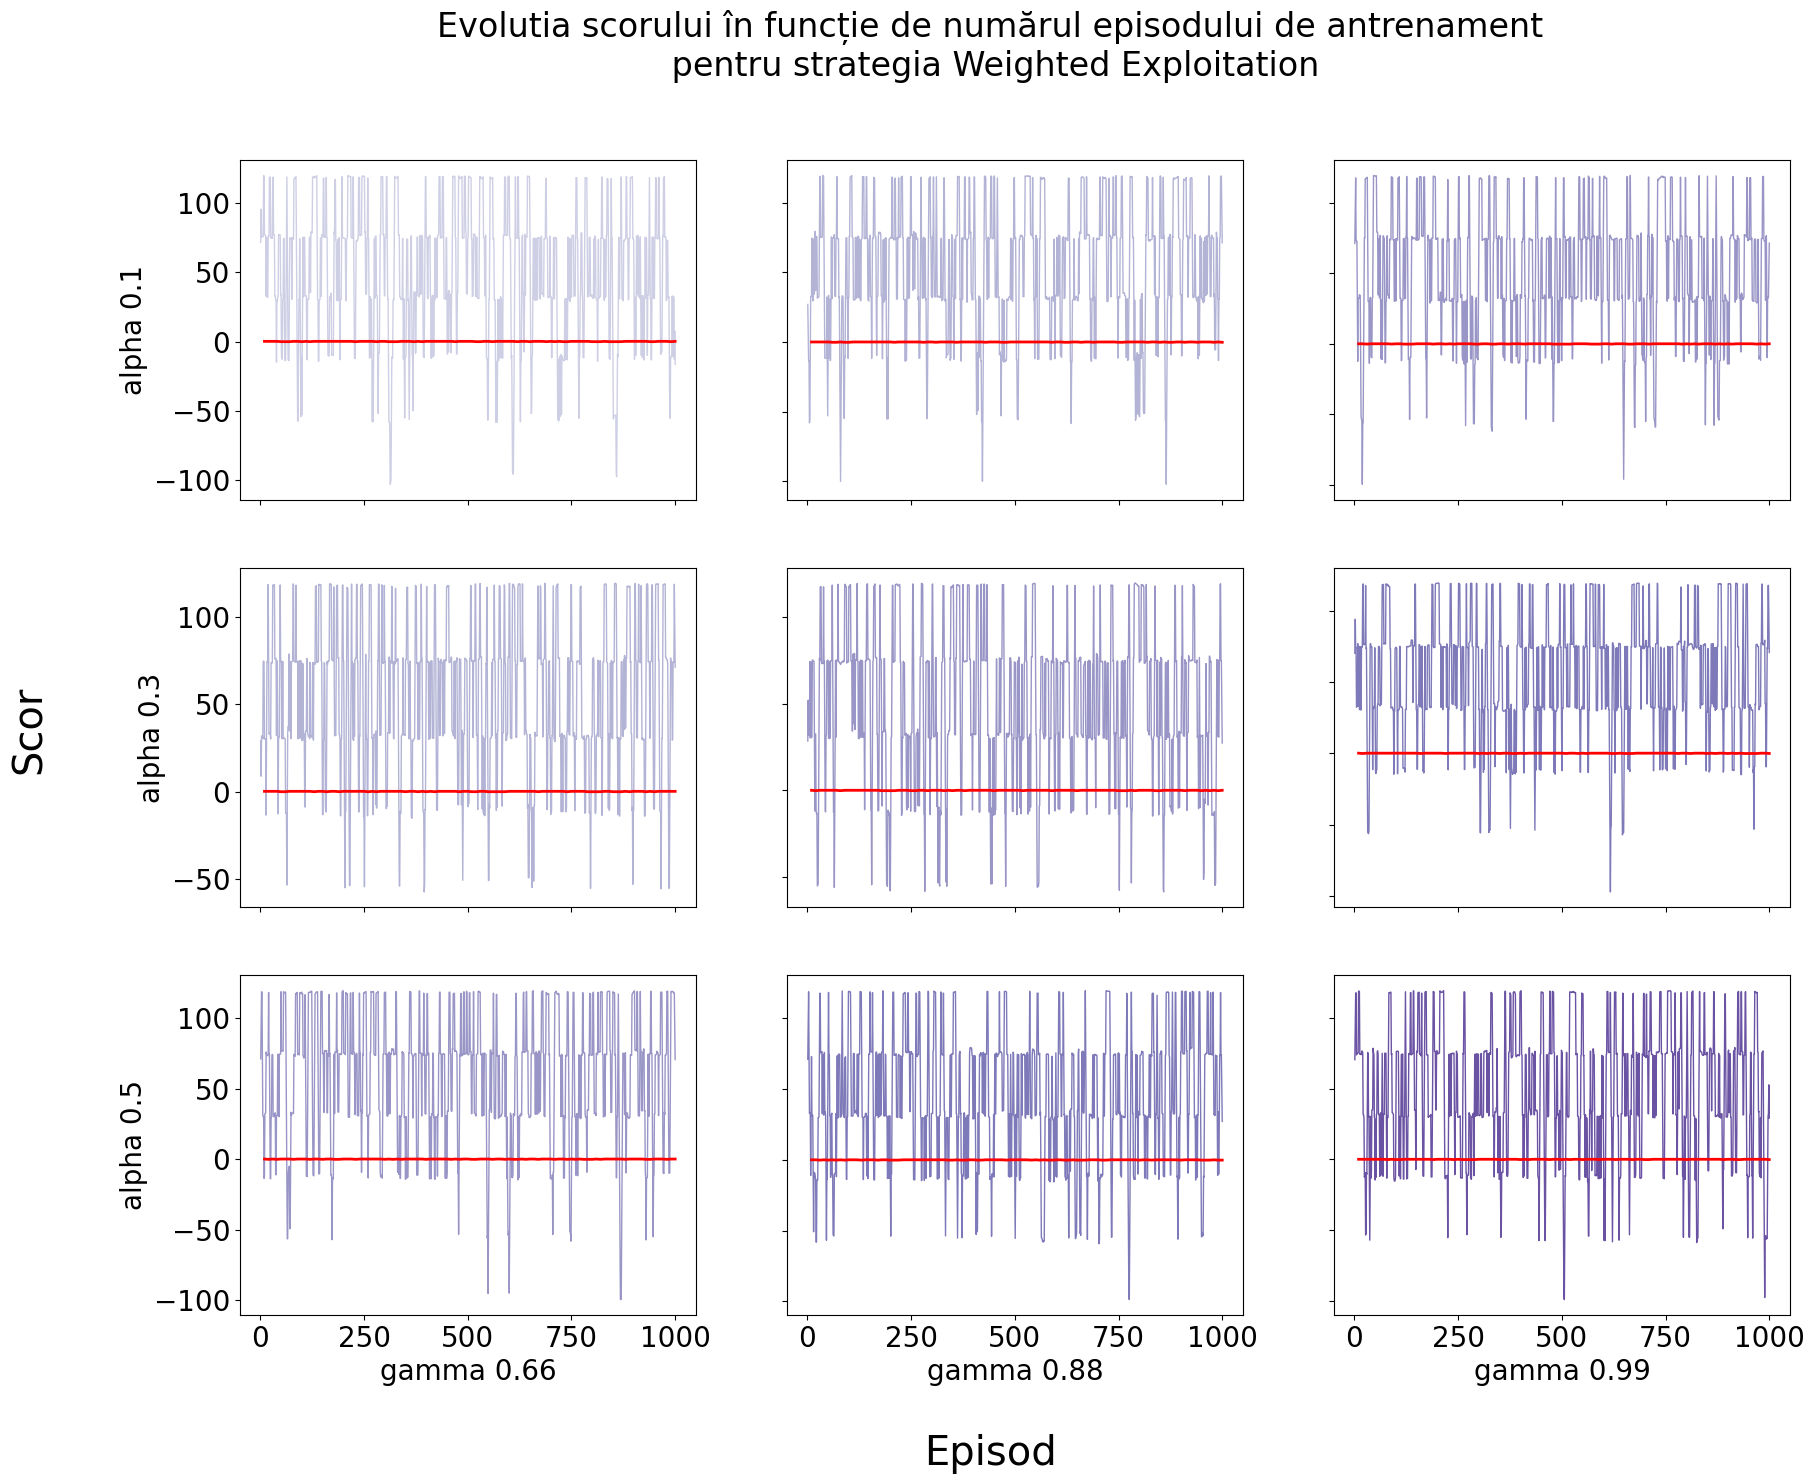

In [16]:
plot_graphs_score_evolution(Strategy.WEIGHTED_EXPLOITATION)

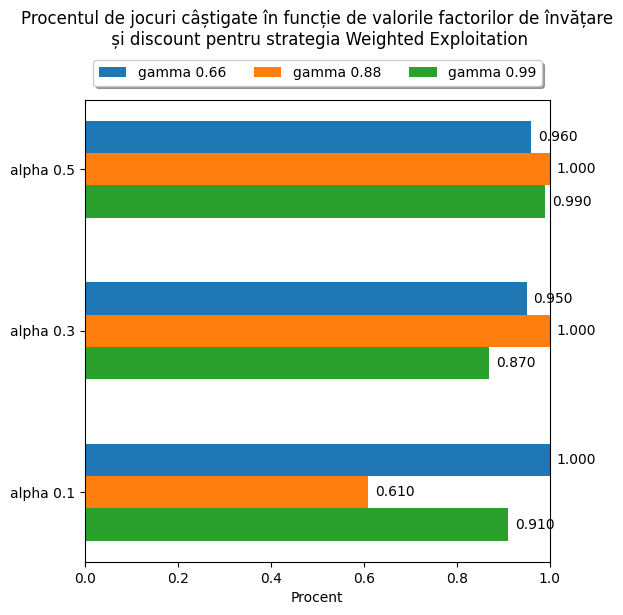

In [17]:
plot_graph_win_rate(Strategy.WEIGHTED_EXPLOITATION)

# Grafice comparative

<ipython-input-9-74c8eee2d6d5>:165: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend((l1, l2), labels=["Max First", "Random"], loc="upper center", bbox_to_anchor=(0.5, 0.94),


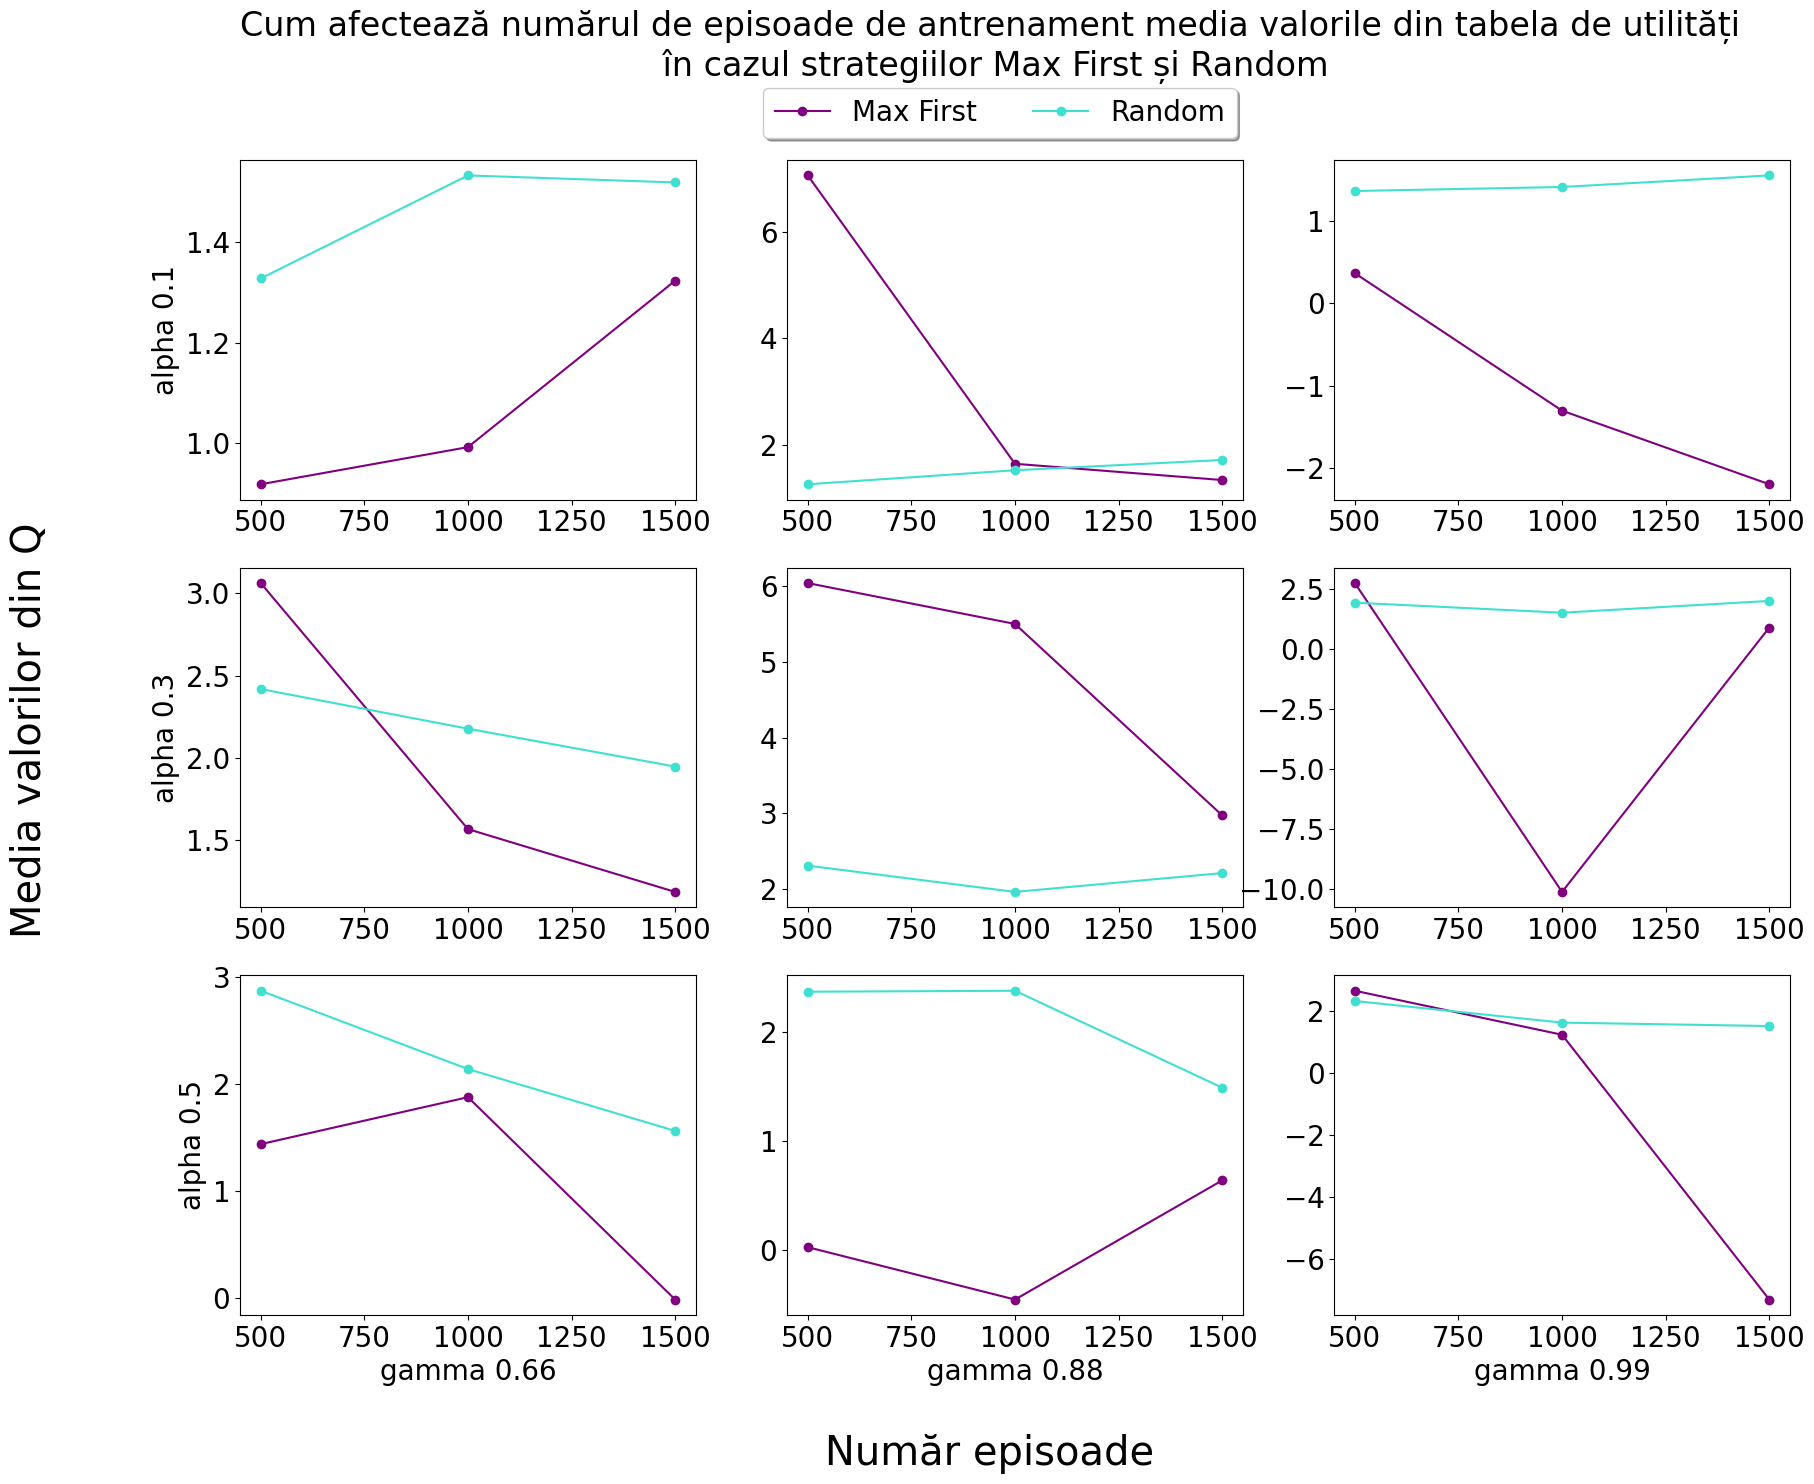

In [18]:
plot_graph_q_max_first_random()

<ipython-input-9-74c8eee2d6d5>:201: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend((l1, l2), labels=["Max First", "Random"], loc="upper center", bbox_to_anchor=(0.5, 0.94),


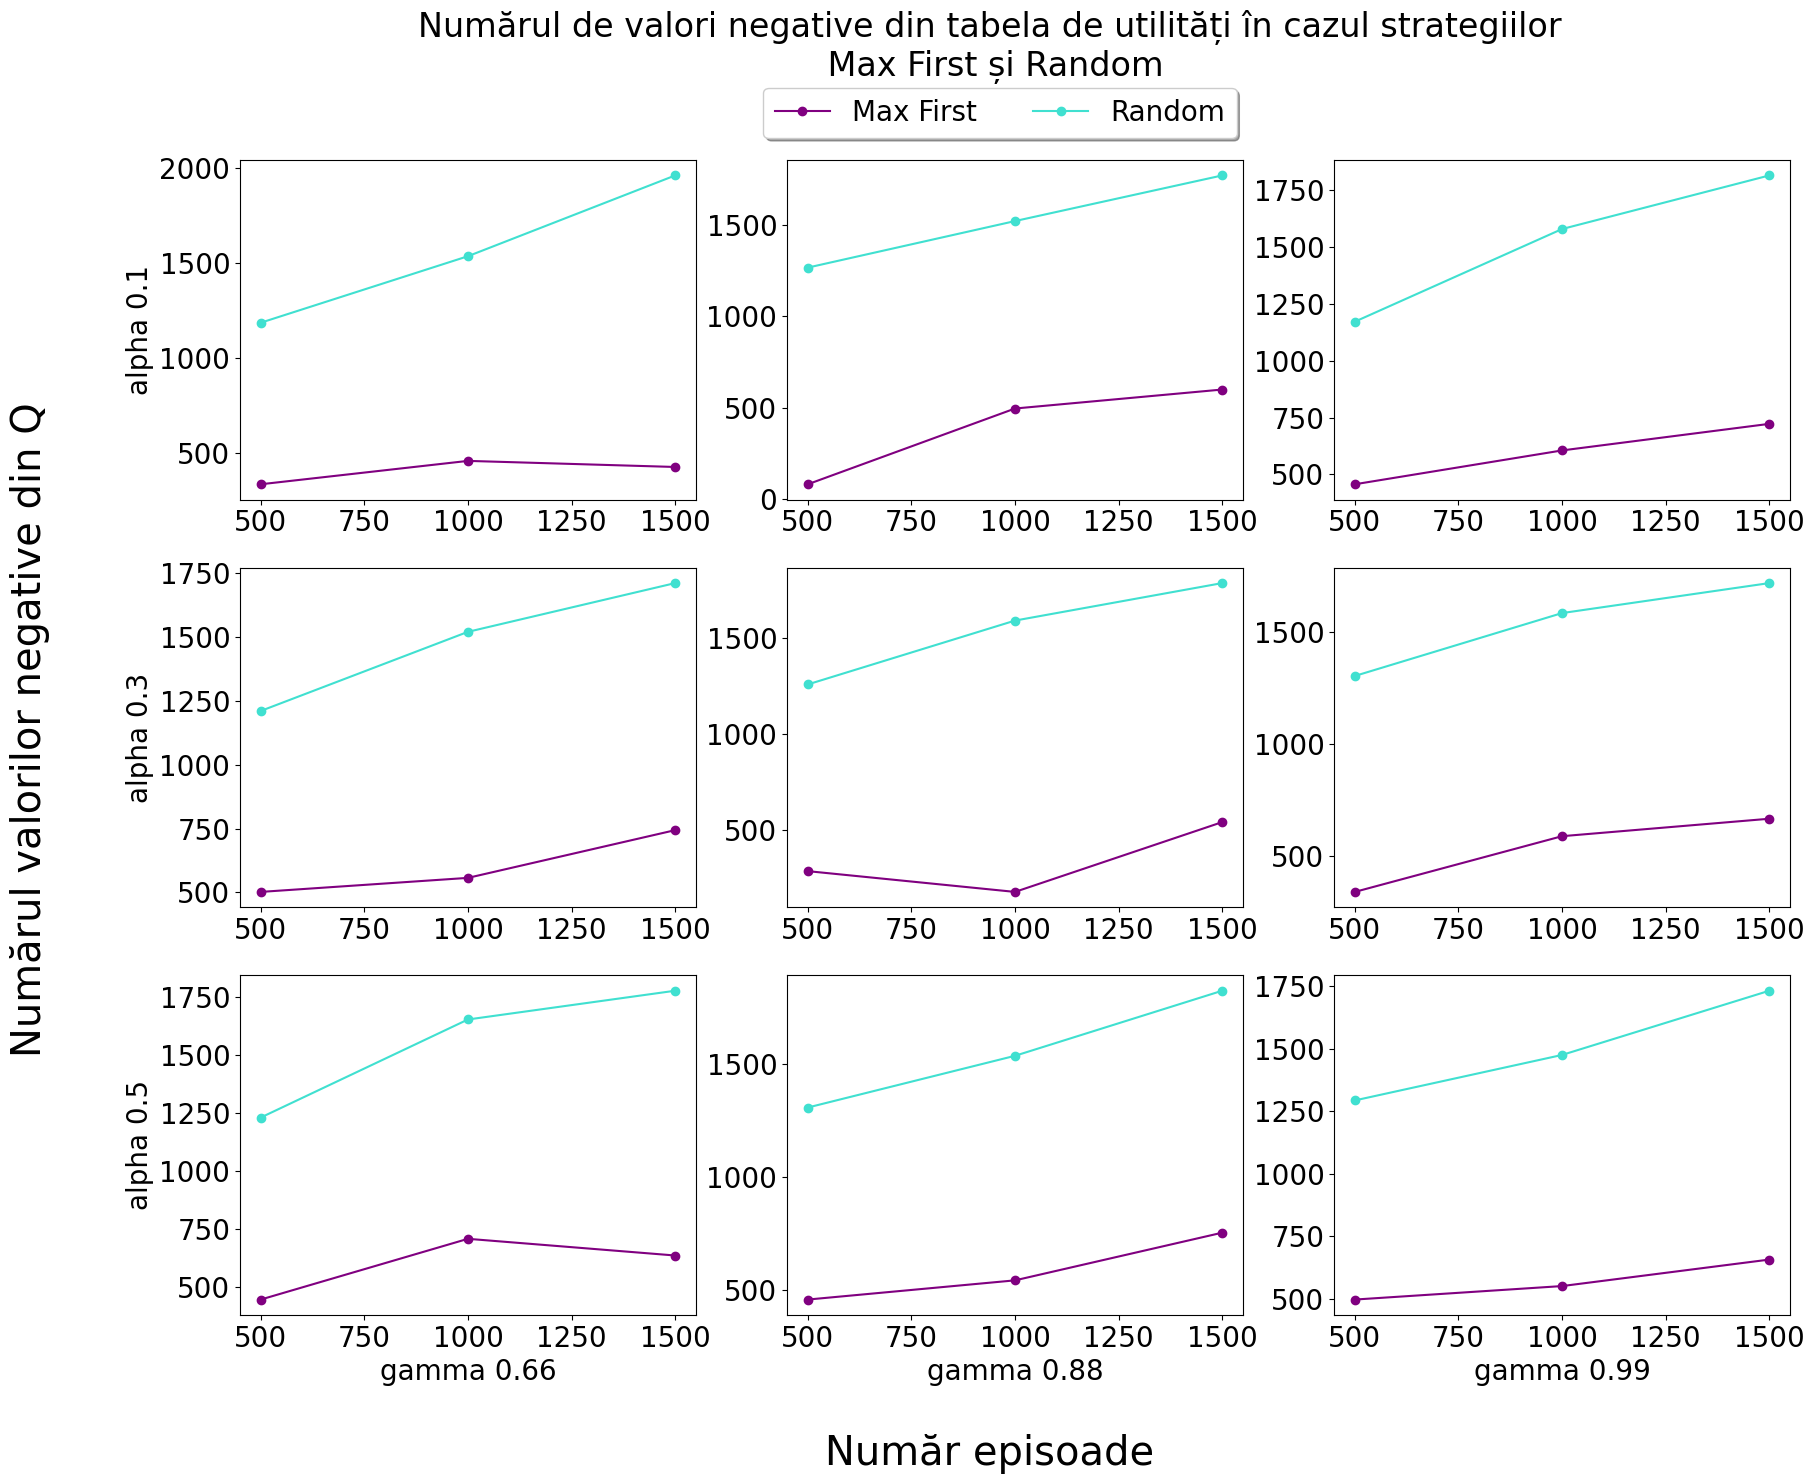

In [19]:
plot_graph_q_max_first_random_neg()